# Kuusito dataset

In [1]:
from pprint import pprint

import pandas as pd
import matplotlib.pyplot as plt
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_curve
from sklift.viz import plot_qini_curve
import numpy as np
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


In [16]:
import statsmodels.api as sm
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

from causalml.inference.meta import BaseXRegressor, BaseRClassifier, BaseSClassifier, BaseTClassifier
from causalml.dataset import *
from causalml.metrics import *

plt.style.use('fivethirtyeight')

%matplotlib inline

In [3]:
df = pd.read_csv('Kuusito.csv')
df.drop(['customer_type'], axis=1, inplace=True)

df = df.replace(r'Value', '', regex=True)
df['target_control'] = df['target_control'].map({'control': 0, 'target': 1})
df['outcome'] = df['outcome'].map({'negative': 0, 'positive': 1})

# df = pd.get_dummies(df)

X = df.drop('outcome', axis=1).astype('int64')
y = df['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

treat_train = X_train['target_control']
treat_test = X_test['target_control']

X_train.drop(['target_control'], axis=1, inplace=True)
X_test.drop(['target_control'], axis=1, inplace=True)

# ATE

In [4]:
def get_mean_target(treatment_flg):
    return df[df['target_control']==treatment_flg]['outcome'].mean()

get_mean_target(1) - get_mean_target(0)

-0.002118776376937581

# Double machine learning

In [5]:
from econml.dml import LinearDMLCateEstimator
from lightgbm import LGBMClassifier

est = LinearDMLCateEstimator(model_y=LGBMClassifier(max_depth=5), 
                             model_t=LGBMClassifier(max_depth=5),
                             discrete_treatment=True)
est.fit(y_train, treat_train, X_train)
uplift = est.const_marginal_effect(X_test)[:, 0]
score = uplift_at_k(y_true=y_test, uplift=uplift, treatment=treat_test, strategy='by_group', k=0.3)

print(f"Uplift at 30: {score}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Uplift at 30: 0.04124744376278122


In [6]:
from econml.dml import NonParamDMLCateEstimator
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

est = NonParamDMLCateEstimator(model_y=LGBMRegressor(),
                               model_t=LGBMRegressor(),
                               model_final=LGBMRegressor())
est.fit(y_train, treat_train, X_train)
uplift = est.effect(X_test.values)
score = uplift_at_k(y_true=y_test, uplift=uplift, treatment=treat_test, strategy='by_group', k=0.3)

print(f"Uplift at 30: {score}")

Uplift at 30: 0.22100204498977505


# Meta Learners

## T-learner

In [7]:
#econml
from econml.metalearners import TLearner

est = TLearner(LGBMClassifier())
est.fit(y_train, treat_train, X_train)
uplift = np.squeeze(est.const_marginal_effect(X_test.values))
score = uplift_at_k(y_true=y_test, uplift=uplift, treatment=treat_test, strategy='by_group', k=0.3)
print(f"econml\t\t| Uplift at 30: {score}")

#causalml
# T Learner
learner_t = BaseTClassifier(learner=LGBMClassifier())
learner_t.fit(X=X_train, treatment=treat_train, y=y_train)
cate_t = np.squeeze(learner_t.predict(X_test.values))
score = uplift_at_k(y_true=y_test, uplift=cate_t, treatment=treat_test, strategy='by_group', k=0.3)
print(f"causalml\t| Uplift at 30: {score}")

#sklift
from sklift.models import TwoModels
tm = TwoModels(estimator_trmnt=LGBMClassifier(), estimator_ctrl=LGBMClassifier(), method='vanilla')
tm = tm.fit(X_train, y_train, treat_train)
uplift_tm = tm.predict(X_test.values)
score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)
print(f"sklift\t\t| Uplift at 30: {score}")

econml		| Uplift at 30: 0.17855214723926377
causalml	| Uplift at 30: 0.2530020449897751
sklift		| Uplift at 30: 0.2530020449897751


<AxesSubplot:title={'center':'Qini curve\nqini_auc_score=0.1789'}, xlabel='Number targeted', ylabel='Number of incremental outcome'>

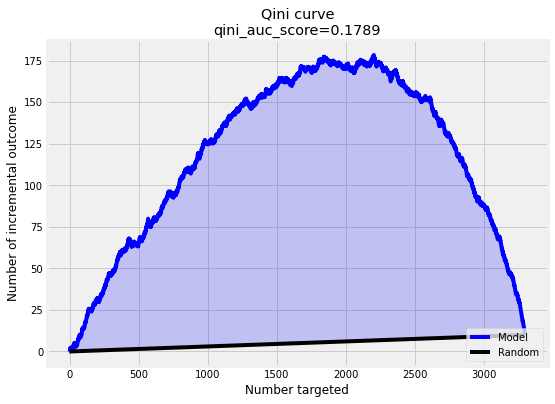

In [8]:
plot_qini_curve(y_true=y_test, uplift=uplift_tm, treatment=treat_test, negative_effect=True, perfect=False)

## S-learner

In [9]:
#econml
from econml.metalearners import SLearner

est = SLearner(LGBMClassifier())
est.fit(y_train, treat_train, X_train)
uplift = np.squeeze(est.const_marginal_effect(X_test.values))
score = uplift_at_k(y_true=y_test, uplift=uplift, treatment=treat_test, strategy='by_group', k=0.3)
print(f"econml\t\t| Uplift at 30: {score}")


#causalml
# S Learner
learner_s = BaseSClassifier(learner=LGBMClassifier())
learner_s.fit(X=X_train, treatment=treat_train, y=y_train)
cate_s = np.squeeze(learner_s.predict(X_test.values))
score = uplift_at_k(y_true=y_test, uplift=cate_s, treatment=treat_test, strategy='by_group', k=0.3)
print(f"causalml\t| Uplift at 30: {score}")


#sklift
from sklift.models import SoloModel

sm = SoloModel(LGBMClassifier())
sm = sm.fit(X_train, y_train, treat_train)
uplift_sm = sm.predict(X_test.values)
score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)
print(f"sklift\t\t| Uplift at 30: {score}")

econml		| Uplift at 30: 0.13405725971370142
causalml	| Uplift at 30: 0.2696319018404908
sklift		| Uplift at 30: 0.2696319018404908


<AxesSubplot:title={'center':'Qini curve\nqini_auc_score=0.1851'}, xlabel='Number targeted', ylabel='Number of incremental outcome'>

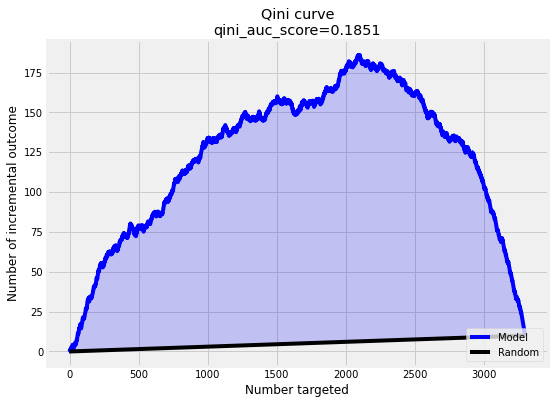

In [10]:
plot_qini_curve(y_true=y_test, uplift=cate_s, treatment=treat_test, negative_effect=True, perfect=False)

## X-Learner

In [17]:
#econml
from econml.metalearners import XLearner

est = XLearner(LGBMClassifier())
est.fit(y_train, treat_train, X_train)
uplift = np.squeeze(est.const_marginal_effect(X_test.values))
score = uplift_at_k(y_true=y_test, uplift=uplift, treatment=treat_test, strategy='by_group', k=0.3)
print(f"econml\t\t| Uplift at 30: {score}")

#causalml
# X Learner
learner_x = BaseXRegressor(LGBMClassifier())
learner_x.fit(X=X_train, treatment=treat_train, y=y_train)
cate_x = np.squeeze(learner_x.predict(X_test.values))
score = uplift_at_k(y_true=y_test, uplift=cate_x, treatment=treat_test, strategy='by_group', k=0.3)
print(f"causalml\t| Uplift at 30: {score}")

econml		| Uplift at 30: 0.21682208588957058
causalml	| Uplift at 30: 0.21682208588957058


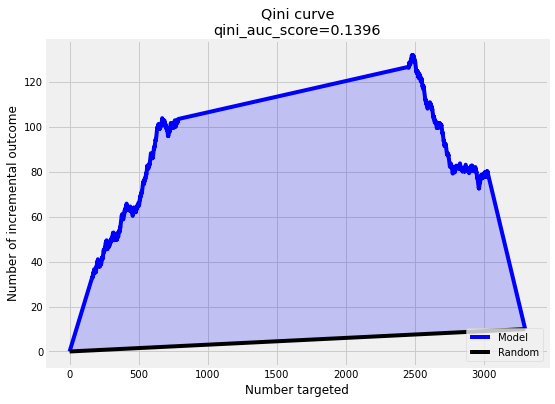

In [18]:
plot_qini_curve(y_true=y_test, uplift=cate_x, treatment=treat_test, perfect=False);